In [2]:
import os
import json
import joblib
import numpy as np
import pandas as pd
from collections import Counter
import pytchat

# ---Visualization------
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for professional thesis charts
sns.set_theme(style="whitegrid")
%matplotlib inline

# ---- Machine Learning  ------
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support, 
    confusion_matrix, 
    classification_report
)

# ---  Deep Learning ---
import torch
from datasets import load_dataset, Dataset
from transformers import (
    DistilBertTokenizer, 
    DistilBertForSequenceClassification, 
    Trainer, 
    TrainingArguments
)

 
print("Ready to start!")

Ready to start!


In [ ]:
#Merging data sets
DATA_FOLDER = "../data"

PATH_DAVIDSON = os.path.join(DATA_FOLDER, "Davidson_dataset.csv")
PATH_HXE      = os.path.join(DATA_FOLDER, "HXE_dataset.json")
PATH_TOXIGEN  = os.path.join(DATA_FOLDER, "ToxiGen_dataset.csv") 

OUTPUT_FILE   = os.path.join(DATA_FOLDER, "Final_Mega_Dataset.csv")

data_frames = []

print(f"---- MERGING DATASETS FROM {DATA_FOLDER} ----")

# DAVIDSON
if os.path.exists(PATH_DAVIDSON):
    df_d = pd.read_csv(PATH_DAVIDSON)
    # Rename columns to match standard (label, text)
    # Assuming original has 'class' and 'tweet'
    df_d = df_d[['class', 'tweet']]
    df_d.columns = ['label', 'text']
    data_frames.append(df_d)
    print(f"[OK] Davidson Loaded: {len(df_d)} rows")
else:
    print(f"[ERR] Missing: {PATH_DAVIDSON}")

# 2. load hatexplain
if os.path.exists(PATH_HXE):
    with open(PATH_HXE, 'r') as f:
        raw_he = json.load(f)
    
    he_rows = []
    for post_id, content in raw_he.items():
        labels = [x['label'] for x in content['annotators']]
        counts = Counter(labels)
        
        if counts.most_common(1)[0][1] == 1: continue 
        
        final_label_str = counts.most_common(1)[0][0]
        
        # Map String -> Number
        if final_label_str == "hatespeech": label = 0
        elif final_label_str == "offensive": label = 1
        elif final_label_str == "normal":    label = 2
        else: continue
            
        text = " ".join(content['post_tokens'])
        he_rows.append({'label': label, 'text': text})
        
    df_h = pd.DataFrame(he_rows)
    data_frames.append(df_h)
    print(f"[OK] HateXplain Loaded: {len(df_h)} rows")
else:
    print(f"[ERR] Missing: {PATH_HXE}")

#load csv
if os.path.exists(PATH_TOXIGEN):
    df_t = pd.read_csv(PATH_TOXIGEN)
    data_frames.append(df_t)
    print(f"[OK] ToxiGen Loaded: {len(df_t)} rows")
else:
    print(f"[ERR] Missing: {PATH_TOXIGEN} (Did you run Cell 1?)")

if data_frames:
    mega_df = pd.concat(data_frames, ignore_index=True)
    
    # Shuffle
    mega_df = mega_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Clean empty rows
    mega_df.dropna(subset=['text'], inplace=True)
    
    # Save
    mega_df.to_csv(OUTPUT_FILE, index=False)
    
    print("\n" + "="*30)
    print(f"Done! ,ega data is saved in: {OUTPUT_FILE}")
    print(f"Total Combined Rows: {len(mega_df)}")
    print("-" * 20)
    print(mega_df['label'].value_counts())
    print("="*30)
else:
    print("no data found to merge.")

---- MERGING DATASETS FROM ../data ----
[OK] Davidson Loaded: 24783 rows
[OK] HateXplain Loaded: 19229 rows
[OK] ToxiGen Loaded: 8960 rows

Done! ,ega data is saved in: ../data\Final_Mega_Dataset.csv
Total Combined Rows: 52972
--------------------
label
1    26256
2    16679
0    10037
Name: count, dtype: int64


 Total Samples:   52972
 Class Balance:
   - Hate (0):      10037 (18.9%)
   - Offensive (1): 26256 (49.6%)
   - Normal (2):    16679 (31.5%)

 Statistics Metrics:
   - Average:       101.88
   - Median:        92.00
   - Max Length:    754
   - 95% cover:     234 chars


C:\Users\parsa\AppData\Local\Temp\ipykernel_20100\2460486746.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=list(distribution.keys()), y=list(distribution.values()), palette="viridis")


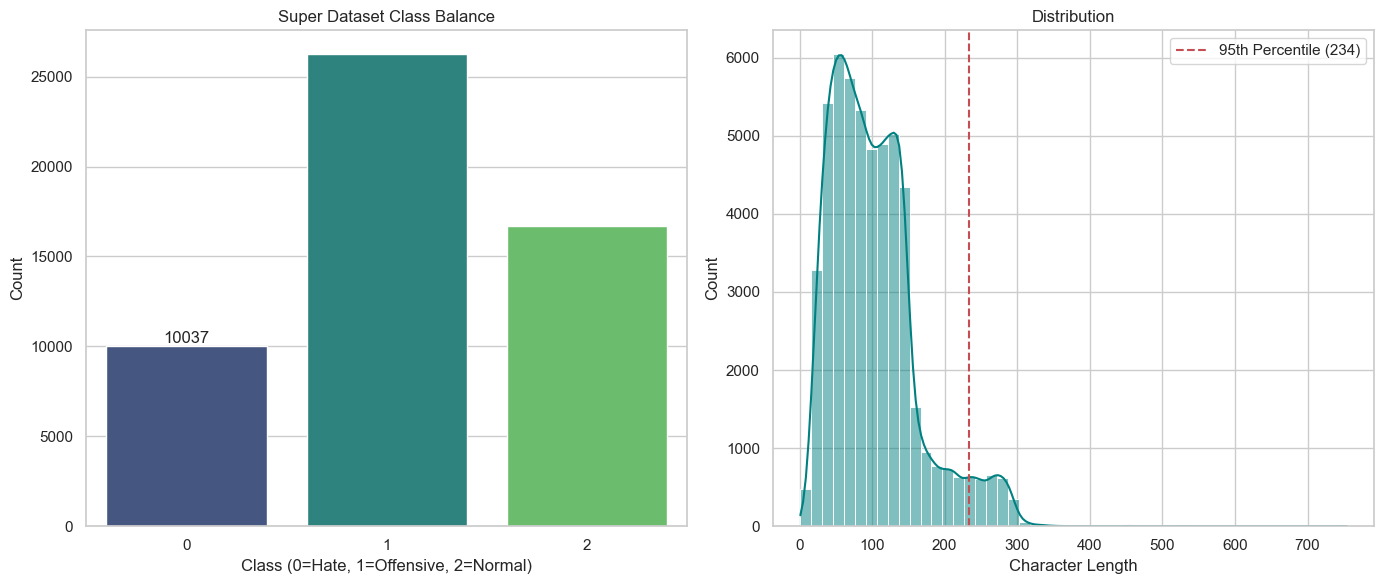

In [8]:
#merge data analytics
#configuration
DATA_FILE = "../data/Final_Mega_Dataset.csv"
# Load Data
if os.path.exists(DATA_FILE):
    df = pd.read_csv(DATA_FILE)
    
    # harmonizing variables     
    df['text'] = df['text'].astype(str)
    labels = df['label'].to_numpy()
    text_lengths = df['text'].str.len().to_numpy()     # This avoids UFuncTypeError 

    # Class Distribution
    unique, counts = np.unique(labels, return_counts=True)
    total_samples = len(labels)
    distribution = dict(zip(unique, counts))
    
    avg_len = np.mean(text_lengths)
    median_len = np.median(text_lengths)
    max_len = np.max(text_lengths)
    std_dev = np.std(text_lengths)
    percentile_95 = np.percentile(text_lengths, 95)

    # --- PRINT THE REPORT ---
    print(f" Total Samples:   {total_samples}")
    print(f" Class Balance:")
    print(f"   - Hate (0):      {distribution.get(0, 0)} ({distribution.get(0, 0)/total_samples:.1%})")
    print(f"   - Offensive (1): {distribution.get(1, 0)} ({distribution.get(1, 0)/total_samples:.1%})")
    print(f"   - Normal (2):    {distribution.get(2, 0)} ({distribution.get(2, 0)/total_samples:.1%})")
    print(f"\n Statistics Metrics:")
    print(f"   - Average:       {avg_len:.2f}")
    print(f"   - Median:        {median_len:.2f}")
    print(f"   - Max Length:    {max_len}")
    print(f"   - 95% cover:     {percentile_95:.0f} chars")

    # ----- visual section -----
    plt.figure(figsize=(14, 6))

    # Chart A:The balance
    plt.subplot(1, 2, 1)
    bar_plot = sns.barplot(x=list(distribution.keys()), y=list(distribution.values()), palette="viridis")
    plt.title("Super Dataset Class Balance")
    plt.xlabel("Class (0=Hate, 1=Offensive, 2=Normal)")
    plt.ylabel("Count")
    plt.bar_label(bar_plot.containers[0])

    # Chart B:Distribution
    plt.subplot(1, 2, 2)
    sns.histplot(text_lengths, bins=50, color="teal", kde=True)
    plt.axvline(percentile_95, color='r', linestyle='--', label=f'95th Percentile ({int(percentile_95)})')
    plt.title("Distribution")
    plt.xlabel("Character Length")
    plt.legend()

    plt.tight_layout()
    plt.show()

else:
    print("Error: Dataset not found.")

----- TRAINING LOGISTIC REGRESSION ----
Training on 42377 samples, Testing on 10595 samples.

------ LR RESULTS -----
               precision    recall  f1-score   support

     Hate (0)       0.58      0.75      0.66      1999
Offensive (1)       0.91      0.72      0.80      5228
   Normal (2)       0.71      0.81      0.75      3368

     accuracy                           0.76     10595
    macro avg       0.73      0.76      0.74     10595
 weighted avg       0.78      0.76      0.76     10595



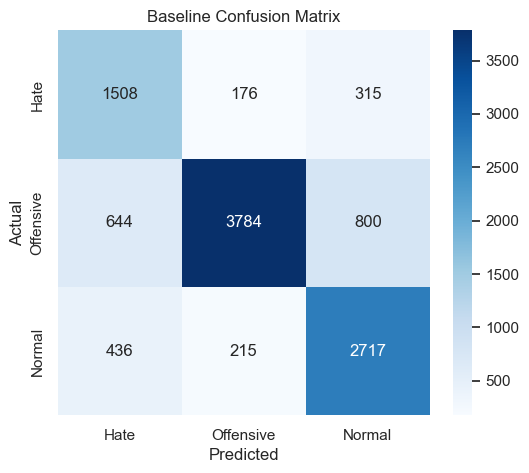

In [9]:
# ----- Logistic Regression -----
print("----- TRAINING LOGISTIC REGRESSION ----")

X = df['text'].astype(str)
y = df['label']

# Split 80% for Training, 20% for Testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training on {len(X_train)} samples, Testing on {len(X_test)} samples.")

# we need to Convert Text to Numbers - > simulating what Spark's HashingTF/IDF does
vectorizer = TfidfVectorizer(max_features=5000) # Keep top 5k words
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train model
model_lr = LogisticRegression(class_weight='balanced', max_iter=1000)
model_lr.fit(X_train_vec, y_train)

# Evaluation
y_pred = model_lr.predict(X_test_vec)


print("\n------ LR RESULTS -----")
print(classification_report(y_test, y_pred, target_names=['Hate (0)', 'Offensive (1)', 'Normal (2)']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Hate', 'Offensive', 'Normal'],
            yticklabels=['Hate', 'Offensive', 'Normal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Baseline Confusion Matrix')
plt.show()

--- TRAINING DistilBERT -----
GPU Detected: NVIDIA GeForce GTX 1650 with Max-Q Design
Running on a subset of 43000 rows...


Map:   0%|          | 0/43000 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


Starting Training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.495972,0.502203,0.799070,0.799476,0.800467,0.799070
2,0.310195,0.533792,0.798721,0.798719,0.798847,0.798721


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].



--- BERT RESULTS ---


{'eval_loss': 0.5021800994873047, 'eval_accuracy': 0.799186046511628, 'eval_f1': 0.7995935493803029, 'eval_precision': 0.8005938280665891, 'eval_recall': 0.799186046511628, 'eval_runtime': 164.1434, 'eval_samples_per_second': 52.393, 'eval_steps_per_second': 3.278, 'epoch': 2.0}


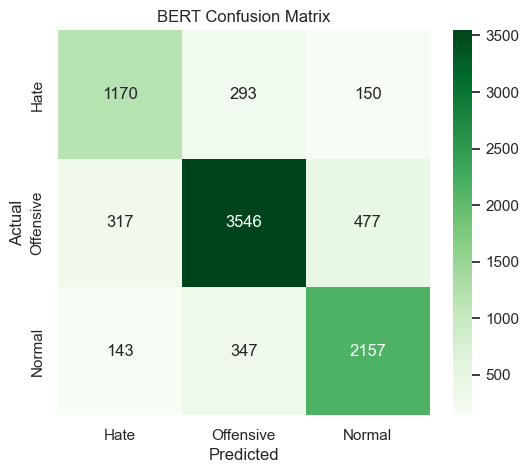

In [11]:
# -----DistilBERT on GPU -----

print("--- TRAINING DistilBERT -----")

#  GPU CHECK for faster calculation
if torch.cuda.is_available():
    print(f"GPU Detected: {torch.cuda.get_device_name(0)}")
else:
    print("GPU not detected.")

# Configuration
SAMPLE_SIZE = 43000 #on  43 k instead of 53k data
if SAMPLE_SIZE:
    df_bert = df.sample(SAMPLE_SIZE, random_state=42)
    print(f"Running on a subset of {SAMPLE_SIZE} rows...")
else:
    df_bert = df
    print(f"Running on FULL dataset ({len(df)} rows)...")

# 2. Tokenization
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

dataset_hf = Dataset.from_pandas(df_bert[['text', 'label']])
tokenized_datasets = dataset_hf.map(tokenize_function, batched=True)

train_test = tokenized_datasets.train_test_split(test_size=0.2)
train_dataset = train_test['train']
test_dataset = train_test['test']

#Model Setup
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

# ML Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16, # Decrease to 8 if you get "Out of Memory" errors
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="epoch",        
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

print("Starting Training...")
trainer.train()

# Evaluation
print("\n--- BERT RESULTS ---")
results = trainer.evaluate()
print(results)

# Confusion Matrix
preds_output = trainer.predict(test_dataset)
y_pred_bert = preds_output.predictions.argmax(-1)
y_true_bert = preds_output.label_ids


cm_bert = confusion_matrix(y_true_bert, y_pred_bert)
plt.figure(figsize=(6,5))
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Hate', 'Offensive', 'Normal'],
            yticklabels=['Hate', 'Offensive', 'Normal'])
plt.title('BERT Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [12]:
# ---- Support Vector Machine -----

print("---  SVM ------")

model_svm = LinearSVC(class_weight='balanced', random_state=42, max_iter=2000)
model_svm.fit(X_train_vec, y_train)

y_pred_svm = model_svm.predict(X_test_vec)

svm_acc = accuracy_score(y_test, y_pred_svm)
svm_p, svm_r, svm_f1, _ = precision_recall_fscore_support(y_test, y_pred_svm, average='weighted')

print("\n--- SVM RESULTS ---")
print(f"Accuracy: {svm_acc:.4f}")
print(f"F1-Score: {svm_f1:.4f}")

---  SVM ------

--- SVM RESULTS ---
Accuracy: 0.7503
F1-Score: 0.7537


--- COMPILING FINAL RESULTS ---

--- FINAL LEADERBOARD ---


,Logistic Regression,SVM (Linear),DistilBERT
Metric,,,
Accuracy,0.755923,0.750260,0.799186
F1-Score (Weighted),0.761116,0.753747,0.799594


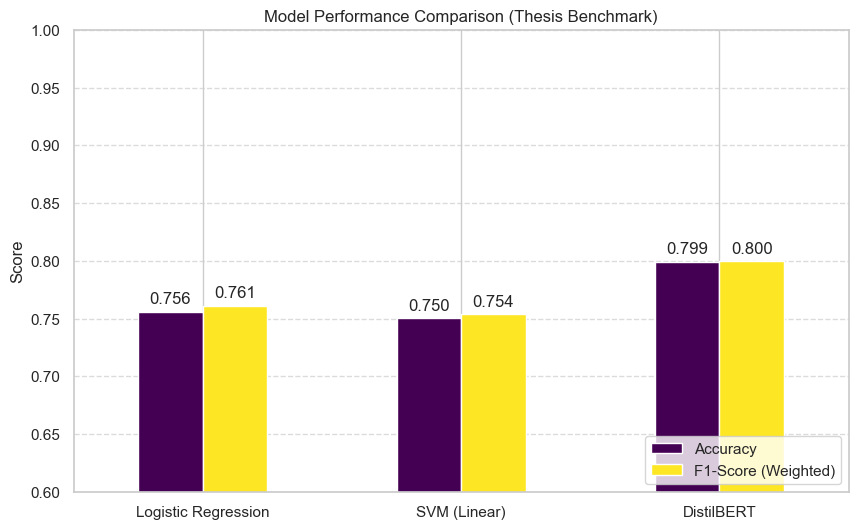

In [14]:
# -----comparison Table -----

print("--- COMPILING FINAL RESULTS ---")

# Retrieve Scores for Model 1 (Logistic Regression)
y_pred_lr = model_lr.predict(X_test_vec)
lr_acc = accuracy_score(y_test, y_pred_lr)
_, _, lr_f1, _ = precision_recall_fscore_support(y_test, y_pred_lr, average='weighted')

# Retrieve Scores for Model 2 (BERT)
bert_acc = results['eval_accuracy'] #from that cell that we ran above
bert_f1 = results['eval_f1']

# Retrieve Scores for Model 3 (SVM)

# Create the Data Table
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1-Score (Weighted)'],
    'Logistic Regression': [lr_acc, lr_f1],
    'SVM (Linear)': [svm_acc, svm_f1],
    'DistilBERT': [bert_acc, bert_f1]
})

comparison_df = comparison_df.set_index('Metric')
print("\n--- FINAL LEADERBOARD ---")
display(comparison_df)

#the Bar Chart
ax = comparison_df.T.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title("Model Performance Comparison (Thesis Benchmark)")
plt.ylabel("Score")
plt.ylim(0.6, 1.0) # Zoom in to see the differences clearly
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.3f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

plt.show()

In [15]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# SAVE ALL MODELS PERMANENTLY


print("----- SAVING MODELS TO DISK ------")
SAVE_FOLDER = "../models"
if not os.path.exists(SAVE_FOLDER):
    os.makedirs(SAVE_FOLDER)
print("Saving Logistic Regression & SVM...")
joblib.dump(model_lr,   os.path.join(SAVE_FOLDER, 'logistic_regression.pkl'))
joblib.dump(model_svm,  os.path.join(SAVE_FOLDER, 'svm_model.pkl'))
joblib.dump(vectorizer, os.path.join(SAVE_FOLDER, 'tfidf_vectorizer.pkl'))

print("Saving BERT...")
trainer.save_model(os.path.join(SAVE_FOLDER, 'bert_final'))
tokenizer.save_pretrained(os.path.join(SAVE_FOLDER, 'bert_final'))

print("\nAll models are safe")

----- SAVING MODELS TO DISK ------
Saving Logistic Regression & SVM...
Saving BERT...


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


All models are safe


In [18]:
# YOUTUBE VOD RECORDER for manual evaluation
#config 
VIDEO_ID = "mAoDkS1ZBw0" 
OUTPUT_FILE = "../data/live_youtube_validation.csv"
TARGET_COUNT = 500

SKIP_MINUTES = 100 #for skippping the beginig of stream to get to engaging part so we have chats(just for faster progress)
seek_seconds = SKIP_MINUTES * 60

print(f"--- downloading chat from : {VIDEO_ID} ---")
print(f"Skipping first {SKIP_MINUTES} minutes...")

chat = pytchat.create(video_id=VIDEO_ID, seektime=seek_seconds)
data = []

try:
    while chat.is_alive():
        # Get a batch of comments
        for c in chat.get().sync_items():
            
            # Print progress every 20 
            if len(data) % 20 == 0:
                print(f"[{len(data)}/{TARGET_COUNT}] grabbed...")
            
            data.append({
                'text': c.message,
                'author': c.author.name,
                'manual_label': '' #for manual labeling
            })
            
            if len(data) >= TARGET_COUNT:
                break
        #if we hit the target
        if len(data) >= TARGET_COUNT:
            break

except Exception as e:
    print(f"Error: {e}")

# Save results
if data:
    df_yt = pd.DataFrame(data)
    df_yt.to_csv(OUTPUT_FILE, index=False)
    print("\n" + "="*40)
    print(f"Saved {len(df_yt)} comments to: {OUTPUT_FILE}")
    print("="*40)
else:
    print("No comments found.")

--- downloading chat from : mAoDkS1ZBw0 ---
Skipping first 100 minutes...
[0/500] grabbed...
[20/500] grabbed...
[40/500] grabbed...
[60/500] grabbed...
[80/500] grabbed...
[100/500] grabbed...
[120/500] grabbed...
[140/500] grabbed...
[160/500] grabbed...
[180/500] grabbed...
[200/500] grabbed...
[220/500] grabbed...
[240/500] grabbed...
[260/500] grabbed...
[280/500] grabbed...
[300/500] grabbed...
[320/500] grabbed...
[340/500] grabbed...
[360/500] grabbed...
[380/500] grabbed...
[400/500] grabbed...
[420/500] grabbed...
[440/500] grabbed...
[460/500] grabbed...
[480/500] grabbed...

Saved 500 comments to: ../data/live_youtube_validation.csv


Original rows loaded: 500
Rows ready for testing: 500
Loading saved models...


Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

Running Statistical Models...
Running BERT...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]


 Final result : 
Logistic Regression: 83.60%
SVM:                 84.60%
BERT:                88.40%


C:\Users\parsa\AppData\Local\Temp\ipykernel_20100\708497636.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=scores, x='Model', y='Accuracy', palette='magma')


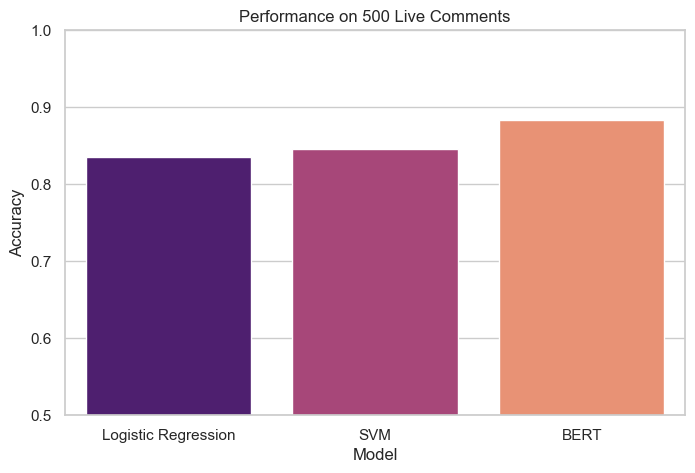

Saved detailed analysis to '../data/final_results_analyzed.csv'


In [ ]:
#final validation
DATA_PATH = "../data/live_youtube_validation.csv" 
MODELS_DIR = "../models"

# load data
if os.path.exists(DATA_PATH):
    try:
        
        # This will swap emojis/weird symbols with a '?' instead of crashing
        df_test = pd.read_csv(DATA_PATH, encoding='utf-8', encoding_errors='replace')
    except:
        print("UTF-8 failed, trying Windows encoding...")
        df_test = pd.read_csv(DATA_PATH, encoding='cp1252', encoding_errors='replace')

    print(f"Original rows loaded: {len(df_test)}")
    
    # Force labels to be numbers to prevent crashes
    df_test['manual_label'] = pd.to_numeric(df_test['manual_label'], errors='coerce')
    df_test = df_test.dropna(subset=['manual_label'])
    df_test['manual_label'] = df_test['manual_label'].astype(int)
    
    print(f"Rows ready for testing: {len(df_test)}")

else:
    print(f"Could not find {DATA_PATH}")
    df_test = pd.DataFrame()

if not df_test.empty:
    print("Loading saved models...")
    try:
        model_lr = joblib.load(os.path.join(MODELS_DIR, 'logistic_regression.pkl'))
        model_svm = joblib.load(os.path.join(MODELS_DIR, 'svm_model.pkl'))
        vectorizer = joblib.load(os.path.join(MODELS_DIR, 'tfidf_vectorizer.pkl'))
        
        tokenizer = DistilBertTokenizer.from_pretrained(os.path.join(MODELS_DIR, 'bert_final'))
        model_bert = DistilBertForSequenceClassification.from_pretrained(os.path.join(MODELS_DIR, 'bert_final'))
    except Exception as e:
        print(f"loading models: {e}")
        raise e

    print("Running Statistical Models...")
    X_vec = vectorizer.transform(df_test['text'].astype(str))
    
    df_test['pred_lr'] = model_lr.predict(X_vec)
    df_test['pred_svm'] = model_svm.predict(X_vec)
    
    print("Running BERT...")
    def tokenize(batch):
        return tokenizer(batch['text'], padding="max_length", truncation=True, max_length=128)
    
    # Convert text column to Dataset format
    ds_test = Dataset.from_pandas(df_test[['text']].astype(str))
    ds_test = ds_test.map(tokenize, batched=True)
    
    trainer = Trainer(model=model_bert)
    bert_output = trainer.predict(ds_test)
    df_test['pred_bert'] = bert_output.predictions.argmax(-1)

    #score
    y_true = df_test['manual_label']
    acc_lr = accuracy_score(y_true, df_test['pred_lr'])
    acc_svm = accuracy_score(y_true, df_test['pred_svm'])
    acc_bert = accuracy_score(y_true, df_test['pred_bert'])
    
    print("\n Final result : ") #for the manual labeled layer
    print(f"Logistic Regression: {acc_lr:.2%}")
    print(f"SVM:                 {acc_svm:.2%}")
    print(f"BERT:                {acc_bert:.2%}")
    
    # 7. CHART
    scores = pd.DataFrame({
        'Model': ['Logistic Regression', 'SVM', 'BERT'],
        'Accuracy': [acc_lr, acc_svm, acc_bert]
    })
    
    plt.figure(figsize=(8, 5))
    sns.barplot(data=scores, x='Model', y='Accuracy', palette='magma')
    plt.title(f"Performance on {len(df_test)} Live Comments")
    plt.ylim(0.5, 1.0) 
    plt.ylabel("Accuracy")
    plt.show()

    df_test.to_csv("../data/final_results_analyzed.csv", index=False)
    print("Saved detailed analysis to '../data/final_results_analyzed.csv'")

              precision    recall  f1-score   support

        Hate       0.25      0.05      0.08        22
   Offensive       0.08      0.03      0.05        29
      Normal       0.91      0.98      0.94       449

    accuracy                           0.88       500
   macro avg       0.41      0.35      0.36       500
weighted avg       0.83      0.88      0.85       500



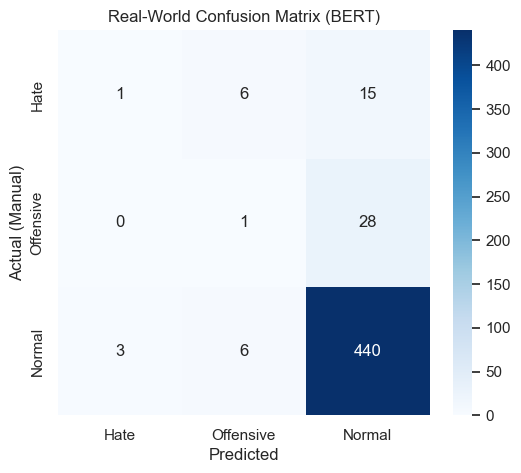

In [21]:
print(classification_report(df_test['manual_label'], df_test['pred_bert'], target_names=['Hate', 'Offensive', 'Normal']))
# Plot the matrix
cm = confusion_matrix(df_test['manual_label'], df_test['pred_bert'])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Hate', 'Offensive', 'Normal'],
            yticklabels=['Hate', 'Offensive', 'Normal'])
plt.xlabel('Predicted')
plt.ylabel('Actual (Manual)')
plt.title('Real-World Confusion Matrix (BERT)')
plt.show()